## Data Exploration

In [1]:

s3_data ="s3://aegovan-data/human_output/human_interactions_ppi_v2.json"
s3_annotations ="s3://aegovan-data/processed_dataset/input_data_pubtator_annotated_human.txt"
s3_results_prefix = "s3://aegovan-data/processed_dataset/"
human_idmapping_dat = "/users/aeg/Downloads/HUMAN_9606_idmapping.dat"
idmapping_dat="./tmpmap.dat"

In [2]:
!cp $human_idmapping_dat $idmapping_dat
!cat $mouse_idmapping_dat >> $idmapping_dat
!wc -l $idmapping_dat

/bin/sh: $idmapping_dat: ambiguous redirect
 6050174 ./tmpmap.dat


In [3]:
import logging, sys

# Set up logging
logging.basicConfig(level=logging.getLevelName("INFO"), handlers=[logging.StreamHandler(sys.stdout)],
                        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')


In [4]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [5]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [6]:
download_single_file(s3_data, data_file)

2021-01-28 22:32:31,659 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


In [7]:
download_single_file(s3_annotations, annotations_file)

In [8]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [9]:
data.pubmedId.nunique()

850

In [10]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Times']
plt.rcParams.update({'font.size': 12})

## Preliminary data transformations

In [11]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)
data["isValid"] =  data.isNegative.isin(['false', '0', 'False'])
data = data.drop('isNegative', axis=1)

### Sneak preview of the data

In [12]:
data.head(n=3)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
10,575312,phosphorylation,"[{'uniprotid': 'P02686-1', 'alias': [['p02686-1'], ['Myelin basic protein'], ['MBP'], ['Myelin A1 protein'], ['Myelin membrane encephalitogenic protein'], ['Golli-MBP1'], ['HOG7']], 'alternative_uniprots': []}, {'uniprotid': 'Q8I629', 'alias': [['q8i629_plaf7'], ['PF3D7_1201600']], 'alternative_uniprot

In [13]:
data.shape

(3381, 7)

In [14]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


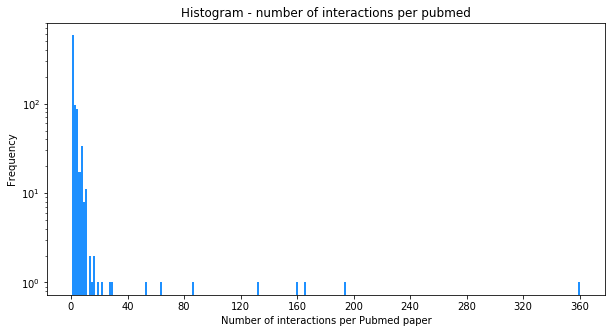

In [15]:
import matplotlib.pyplot as plt
import numpy as np 

ax = plt.axes( yscale='log')
ax.xaxis.set_major_locator(plt.MaxNLocator(10, prune='lower'))

#sns.distplot(data.pubmedId.value_counts().tolist(), bins=100, kde=False, norm_hist=True)

data.pubmedId.value_counts().plot.hist (bins=250,figsize=(10,5), ax=ax, color='dodgerblue')
plt.title('Histogram - number of interactions per pubmed')
plt.xlabel('Number of interactions per Pubmed paper')
plt.ylabel('Frequency')
#plt.show()
plt.savefig('PaperVsInteractions.eps', bbox_inches='tight')
plt.savefig('PaperVsInteractions.png', bbox_inches='tight')
plt.show()

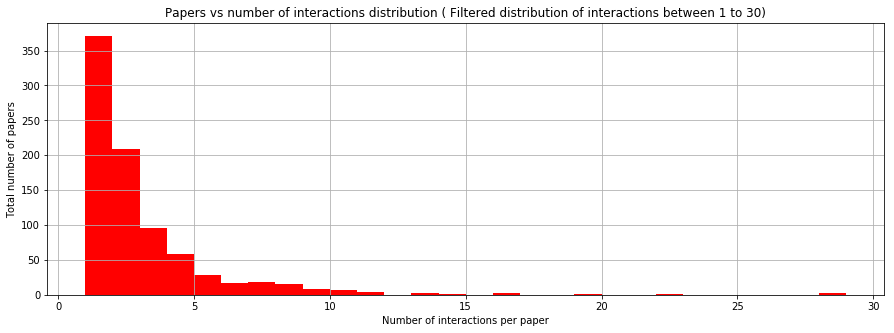

In [16]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

### Interaction Types distribution

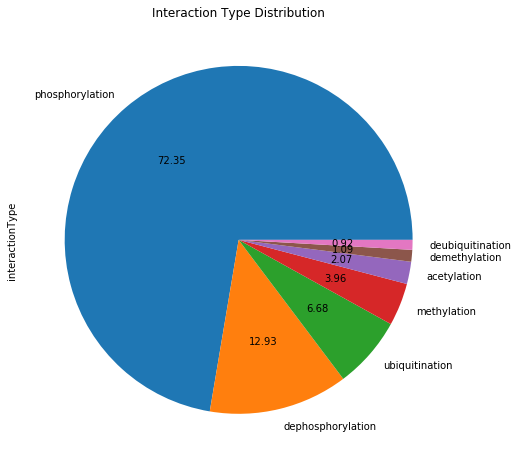

In [17]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(8, 8))
plt.title('Interaction Type Distribution')
plt.savefig("Interactiontype.svg")
plt.show()

In [18]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,2446
dephosphorylation,437
ubiquitination,226
methylation,134
acetylation,70
demethylation,37
deubiquitination,31


### Distinct interaction types per paper

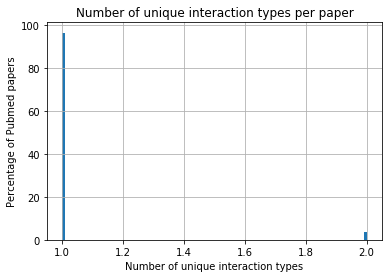

In [19]:
import numpy as np

distinct_no_papers = data['pubmedId'].nunique()

data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100, density=1)
plt.title("Number of unique interaction types per paper")
plt.xlabel('Number of unique interaction types')
plt.ylabel('Percentage of Pubmed papers'.format(distinct_no_papers))
plt.show()


### Postive vs Negative Relationships

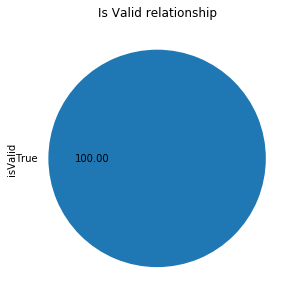

In [20]:
data.isValid.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Valid relationship')
plt.show()

### Number of participants per interaction

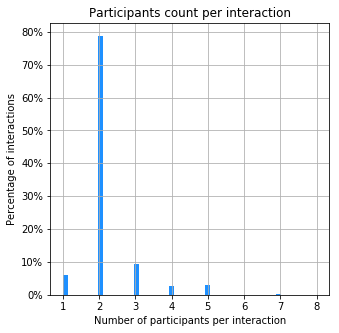

In [21]:
import numpy as np
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())

data['participants_count'] = data["participants"].apply(lambda x: len(x))

data['participants_count'].hist (bins=50, ax=c_ax, figsize=(5,5), color = 'dodgerblue',  weights = np.ones_like(data['participants_count'].index)*100 / len(data['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Explore if the abstract contains the trigger word

In [22]:
!pip install nltk==3.4.5

You should consider upgrading via the 'pip install --upgrade pip' command.


In [23]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

stemmer = PorterStemmer()
print(pd.DataFrame(data.interactionType.unique()).apply(lambda r: stemmer.stem(r.iloc[0].lower()), axis=1))

data["hasTriggerWord"] = data.apply(lambda r: stemmer.stem(r["interactionType"].lower()) in r["pubmedabstract"].lower() , 1)

0      phosphoryl
1     deubiquitin
2          methyl
3        demethyl
4          acetyl
5       ubiquitin
6    dephosphoryl
dtype: object


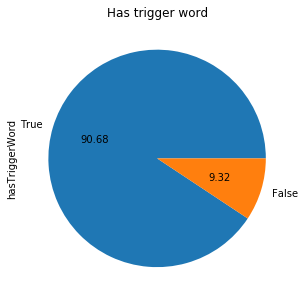

In [24]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

In [25]:
data.groupby([ 'interactionType','hasTriggerWord']).size().unstack().apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,False,True
interactionType,,
acetylation,7.1,92.9
demethylation,2.7,97.3
dephosphorylation,11.4,88.6
deubiquitination,22.6,77.4
methylation,0.7,99.3
phosphorylation,10.1,89.9
ubiquitination,1.8,98.2


### Explore how many of the entity alias are mentioned in the abstract

In [26]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

CPU times: user 25.3 s, sys: 164 ms, total: 25.4 s
Wall time: 27.4 s


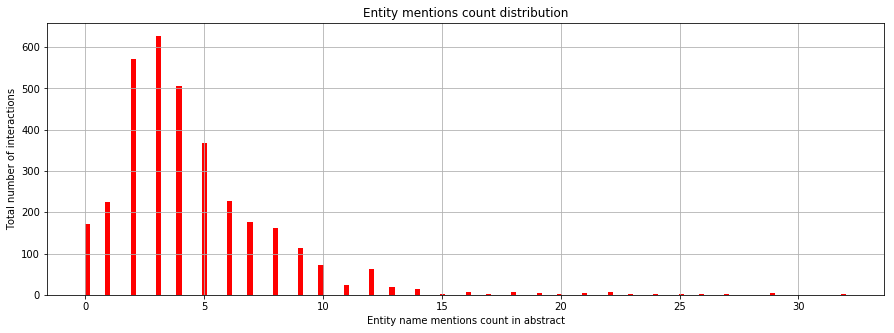

In [27]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

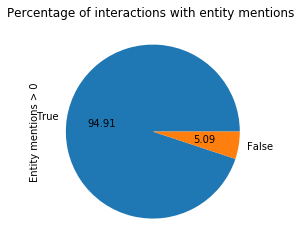

In [28]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [29]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=3)


,participants,pubmedabstract
719,"[{'uniprotid': 'Q14011', 'alias': [['cirbp_human'], ['Cold-inducible RNA-binding protein'], ['Glycine-rich RNA-binding protein CIRP'], ['A18 hnRNP'], ['CIRBP'], ['A18HNRNP'], ['CIRP']], 'alternative_uniprots': ['B4E2X2', 'B3KT17']}, {'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
751,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'Q92841-4', 'alias': [['q92841-4'], ['Probable ATP-dependent RNA helicase DDX17'], ['DEAD box protein p82'], ['DDX17'], ['DEAD box protein 17'], ['DEAD box protein p72'], ['RNA-dependent helicase p72'], ['p82']], 'alternative_uniprots': []}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
698,"[{'uniprotid': 'Q13547', 'alias': [['hdac1_human'], ['Histone deacetylase 1'], ['HDAC1'], ['RPD3L1']], 'alternative_uniprots': ['Q92534']}, {'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."


In [30]:
data.head(n=2)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid,participants_count,hasTriggerWord,entityMentionsCount
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,2,True,9
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,2,True,9


## Data Transformation

### Filter interactions with more than 2 participants

In [31]:
filtered = data.query('participants_count <= 2')
filtered.shape

(2868, 10)

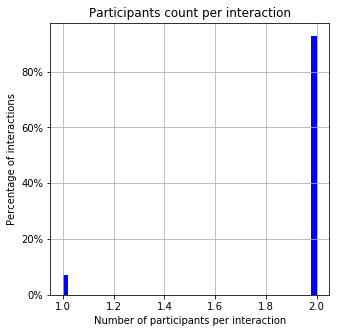

In [32]:
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
filtered['participants_count'].hist (bins=50, figsize=(5,5), ax=c_ax, color = 'blue',  weights = np.ones_like(filtered['participants_count'].index)*100 / len(filtered['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Filter out interactions from paper with more than 15 interactions

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


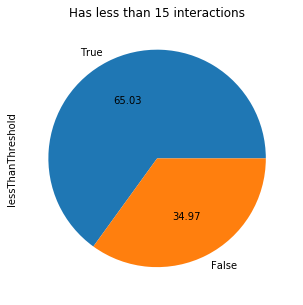

In [33]:
pubmed_interaction_count = filtered.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


#interactions_count= pd.DataFrame()
filtered["lessThanThreshold"] = filtered.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


filtered.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has less than 15 interactions')
plt.show()

In [34]:
filtered = filtered.query("lessThanThreshold == 1")

In [35]:
print("Total number of records after filter: {}".format(filtered.shape[0]))

Total number of records after filter: 1865


###  Flatten partcipants into participant 1 and particpiant 2

In [36]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(filtered)


In [37]:
data_transformed.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."


In [38]:
data_transformed.shape

(1865, 14)

### Remove records where the participantId is null

In [39]:
data_transformed.shape

(1865, 14)

In [40]:
data_filtered = data_transformed[data_transformed.participant1Id.notnull()]
data_filtered.shape

(1795, 14)

In [41]:
data_filtered = data_filtered[data_filtered.participant2Id.notnull()]
data_filtered.shape

(1766, 14)

In [42]:
data_filtered.head(n=2)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."
1,9,True,1585516,phosphorylation,True,True,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-1,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation."


### Normalise abstract

In [43]:

def normalise_absract(data, enity_annotations_file):
    from datatransformer.abstractGeneNormaliser import AbstractGeneNormaliser
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper
    from datatransformer.ncbiGeneUniprotMapper import NcbiGeneUniprotMapper


    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.textGeneNormaliser import TextGeneNormaliser


    import os
    
 
    localdb = idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
        
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))
        
        
        # 
        normaliser = AbstractGeneNormaliser(annotations_json)
        normaliser.text_gene_normaliser = TextGeneNormaliser(geneIdConverter = mapper) 
        result = normaliser.transform(data)
        
       

        return result

In [44]:
%%time

data_filtered = normalise_absract(data_filtered, annotations_file)

2021-01-28 22:33:38,489 - datatransformer.abstractGeneNormaliser - INFO - Starting transformation..
2021-01-28 22:33:44,309 - datatransformer.abstractGeneNormaliser - INFO - Completed normalised abstract...
2021-01-28 22:33:44,310 - datatransformer.abstractGeneNormaliser - INFO - Adding annotations ...
2021-01-28 22:33:44,458 - datatransformer.abstractGeneNormaliser - INFO - Adding annotations_abstract...
2021-01-28 22:33:44,491 - datatransformer.abstractGeneNormaliser - INFO - Adding num_unique_gene_normalised_id...
2021-01-28 22:33:44,504 - datatransformer.abstractGeneNormaliser - INFO - Adding num_gene_normalised_id...
2021-01-28 22:33:44,522 - datatransformer.abstractGeneNormaliser - INFO - Gene Id links...
2021-01-28 22:33:44,546 - datatransformer.abstractGeneNormaliser - INFO - Completed transformation
CPU times: user 4.86 s, sys: 165 ms, total: 5.03 s
Wall time: 6.13 s


In [45]:
data_filtered.shape

(1766, 20)

In [46]:
data_filtered.head(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map
0,9,True,1585513,phosphorylation,True,True,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]",Q10728,"[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]",O43293-2,2,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.","O43293 (O43293) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that O43293 also plays a role in regulating Q7Z406 phosphorylation. Here, we found novel O43293 isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to O14974(O14974) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to Q7Z406. These results indicate that a leucine zipper is not critical for the binding of O43293 to O14974 and Q7Z406. Consistently, hZIPK-S localized with stress-fibers where they co-localized with Q7Z406. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to O14974, while the Q7Z406 binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of Q7Z406 phosphorylation.","[{'start': '0', 'end': '33', 'name': 'Zipper-interacting protein kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '35', 'end': '45', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '197', 'end': '207', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '240', 'end': '246', 'name': 'myosin', 'type': 'Gene', 'normalised_id': '79784'}, {'start': '285', 'end': '295', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '416', 'end': '454', 'name': 'myosin phosphatase targeting subunit 1', 'type': 'Gene', 'normalised_id': '4659'}, {'start': '455', 'end': '460', 'name': 'MYPT1', 'type': 'Gene', 'normalised_id': '4659'}, {'start': '563', 'end': '569', 'name': 'myosin', 'type': 'Gene', 'normalised_id': '79784'}, {'start': '651', 'end': '661', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '665', 'end': '670', 'name': 'MYPT1', 'type': 'Gene', 'normalised_id': '4659'}, {

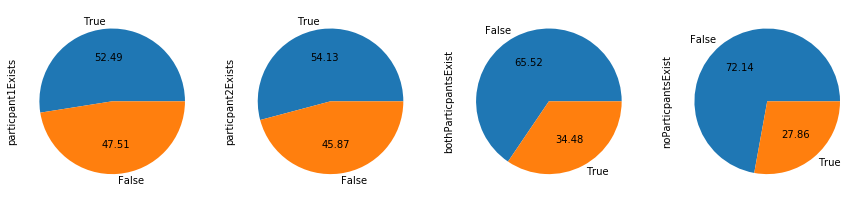

In [47]:

fig, ax =  plt.subplots( 1,4, figsize=(15,5))

tmp = pd.DataFrame()

data_filtered["particpant1Exists"] = data_filtered.apply(lambda r: r["participant1Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant1Exists"].value_counts().plot.pie(ax=ax[0], autopct='%.2f')

data_filtered["particpant2Exists"] = data_filtered.apply(lambda r: r["participant2Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant2Exists"].value_counts().plot.pie(ax=ax[1], autopct='%.2f')


data_filtered["bothParticpantsExist"] = data_filtered.apply(lambda r: r["particpant2Exists"] and r["particpant1Exists"]   , 1)
data_filtered["bothParticpantsExist"].value_counts().plot.pie(ax=ax[2], autopct='%.2f')

data_filtered["noParticpantsExist"] = data_filtered.apply(lambda r: not (r["particpant2Exists"] or r["particpant1Exists"])   , 1)
data_filtered["noParticpantsExist"].value_counts().plot.pie(ax=ax[3], autopct='%.2f')


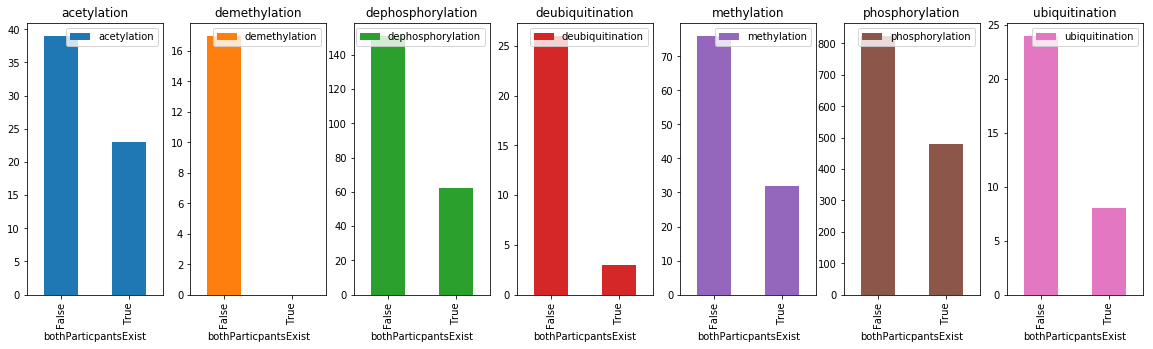

In [48]:
fig, ax = plt.subplots(1,7, figsize=(20,5))

data_filtered.groupby([ "bothParticpantsExist", 'interactionType']).size().unstack().plot.bar(subplots=True, ax=ax)
plt.show()

In [49]:
data_filtered.query("particpant2Exists == False").sample(4)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
1695,2,True,573749,phosphorylation,True,True,"[[pdk1_human], [[Pyruvate dehydrogenase (acetyl-transferring)] kinase isozyme 1, mitochondrial], [PDK1], [PDHK1], [Pyruvate dehydrogenase kinase isoform 1]]",Q15118,"[[pkn2_human], [Serine/threonine-protein kinase N2], [PKN2], [PRK2], [PRKCL2], [Protein kinase C-like 2], [Protein-kinase C-related kinase 2], [PKN gamma]]",Q16513,2,17110931,None,"Organisms rely heavily on protein phosphorylation to transduce intracellular signals. The phosphorylation of a protein often induces conformational changes, which are responsible for triggering downstream cellular events. Protein kinases are themselves frequently regulated by phosphorylation. Recently, we and others proposed the molecular mechanism by which phosphorylation at a hydrophobic motif (HM) regulates the conformation and activity of many members of the AGC group of protein kinases. Here we have developed specific, low molecular weight compounds, which target the HM/PIF-pocket and have the ability to allosterically activate phosphoinositide-dependent protein kinase 1 (PDK1) by modulating the phosphorylation-dependent conformational transition. The mechanism of action of these compounds was characterized by mutagenesis of PDK1, synthesis of compound analogs, interaction-displacement studies and isothermal titration calorimetry experiments. Our results raise the possibility of developing drugs that target the AGC kinases via a novel mode of action and may inspire future rational development of compounds with the ability to modulate phosphorylation-dependent conformational transitions in other proteins.","Organisms rely heavily on protein phosphorylation to transduce intracellular signals. The phosphorylation of a protein often induces conformational changes, which are responsible for triggering downstream cellular events. Protein kinases are themselves frequently regulated by phosphorylation. Recently, we and others proposed the molecular mechanism by which phosphorylation at a hydrophobic motif (HM) regulates the conformation and activity of many members of the AGC group of protein kinases. Here we have developed specific, low molecular weight compounds, which target the HM/Q9H611-pocket and have the ability to allosterically activate Q15118 (Q15118) by modulating the phosphorylation-dependent conformational transition. The mechanism of action of these compounds was characterized by mutagenesis of Q15118, synthesis of compound analogs, interaction-displacement studies and isothermal titration calorimetry experiments. Our results raise the possibility of developing drugs that target the AGC kinases via a novel mode of action and may inspire future rational development of compounds with the ability to modulate phosphorylation-dependent conformational transitions in other proteins.","[{'start': '582', 'end': '585', 'name': 'PIF', 'type': 'Gene', 'normalised_id': '80119'}, {'start': '641', 'end': '684', 'name': 'phosphoinositide-dependent protein kinase 1', 'type': 'Gene', 'normalised_id': '5163'}, {'start': '686', 'end': '690', 'name': 'PDK1', 'type': 'Gene', 'normalised_id': '5163'}, {'start': '842', 'end': '846', 'name': 'PDK1', 'type': 'Gene', 'normalised_id': '5163'}]","Organisms rely heavily on protein phosphorylation to transduce intracellular signals. The phosphorylation of a protein often induces conformational changes, which are responsible for triggering downstream cellular events. Protein kinases are themselves frequently regulated by phosphorylation. Recently, we and others proposed the molecular mechanism by which ph

### Remove abstracts where both participants do not exists

In [50]:
data_filtered =  data_filtered.query('bothParticpantsExist == True')
data_filtered.shape

(609, 24)

### Remove self relations

In [51]:
data_filtered =  data_filtered.query('participant1Id != participant2Id')
data_filtered.shape

(436, 24)

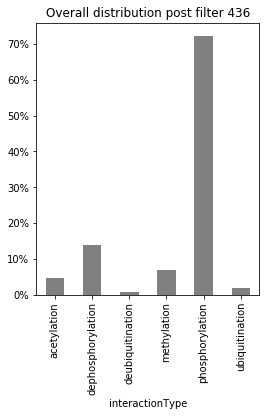

In [52]:
fig, ax = plt.subplots( 1,1, figsize=(4,5))

c_ax= ax
c_ax.set_title('Overall distribution post filter {}'.format(data_filtered.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))

data_filtered.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(data_filtered.interactionType))).plot.bar(ax=c_ax, color='gray')


plt.savefig("Interactiontype_postfilter.eps", bbox_inches='tight')
plt.savefig("Interactiontype_postfilter.png", bbox_inches='tight')


plt.show()

#### Check how many contain the trigger word

In [53]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0)

hasTriggerWord,False,True
interactionType,,
acetylation,2,18
dephosphorylation,10,50
deubiquitination,0,3
methylation,0,30
phosphorylation,15,300
ubiquitination,0,8


In [54]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0).apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,False,True
interactionType,,
acetylation,10.0,90.0
dephosphorylation,16.7,83.3
deubiquitination,0.0,100.0
methylation,0.0,100.0
phosphorylation,4.8,95.2
ubiquitination,0.0,100.0


In [55]:
data_filtered.query('pubmedId == "17126281"')

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist


### Split Train/Test/validation

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_pubmed = data_filtered.pubmedId.unique()
stratified =  [ data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in unique_pubmed]
trainpubmed, valpubmed  = train_test_split(unique_pubmed,  test_size=.1,
                                                        random_state=777, stratify=stratified)


stratified =  [data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in trainpubmed]
trainpubmed, testpubmed = train_test_split(trainpubmed,  test_size=.2,
                                                        random_state=777, stratify=stratified)

In [57]:
data_filtered.query("interactionType == 'demethylation'")['pubmedId'].unique()

array([], dtype=object)

In [58]:
data_filtered.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '16213503', '14603323', '11894096', '11882901',
       '19656744', '16601676', '11027293'], dtype=object)

In [59]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]




In [60]:
train.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['16213503', '11894096', '11882901', '19656744', '16601676',
       '11027293'], dtype=object)

In [61]:
val.query("interactionType == 'ubiquitination'")


,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
1093,3,True,131488,ubiquitination,True,True,"[[fbw1a_human], [F-box/WD repeat-containing protein 1A], [BTRC], [BTRCP], [FBW1A], [FBXW1A], [F-box and WD repeats protein beta-TrCP], [E3RSIkappaB], [pIkappaBalpha-E3 receptor subunit], [Epididymis tissue protein Li 2a]]",Q9Y297,"[[mpip1_human], [M-phase inducer phosphatase 1], [Dual specificity phosphatase Cdc25A], [CDC25A]]",P30304,2,14603323,None,"The Cdc25A phosphatase is essential for cell-cycle progression because of its function in dephosphorylating cyclin-dependent kinases. In response to DNA damage or stalled replication, the ATM and ATR protein kinases activate the checkpoint kinases Chk1 and Chk2, which leads to hyperphosphorylation of Cdc25A. These events stimulate the ubiquitin-mediated proteolysis of Cdc25A and contribute to delaying cell-cycle progression, thereby preventing genomic instability. Here we report that beta-TrCP is the F-box protein that targets phosphorylated Cdc25A for degradation by the Skp1/Cul1/F-box protein complex. Downregulation of beta-TrCP1 and beta-TrCP2 expression by short interfering RNAs causes an accumulation of Cdc25A in cells progressing through S phase and prevents the degradation of Cdc25A induced by ionizing radiation, indicating that beta-TrCP may function in the intra-S-phase checkpoint. Consistent with this hypothesis, suppression of beta-TrCP expression results in radioresistant DNA synthesis in response to DNA damage--a phenotype indicative of a defect in the intra-S-phase checkpoint that is associated with an inability to regulate Cdc25A properly. Our results show that beta-TrCP has a crucial role in mediating the response to DNA damage through Cdc25A degradation.","The P30304 phosphatase is essential for cell-cycle progression because of its function in dephosphorylating cyclin-dependent kinases. In response to DNA damage or stalled replication, the ATM and ATR protein kinases activate the checkpoint kinases O14757 and O96017, which leads to hyperphosphorylation of P30304. These events stimulate the ubiquitin-mediated proteolysis of P30304 and contribute to delaying cell-cycle progression, thereby preventing genomic instability. Here we report that Q9Y297 is the F-box protein that targets phosphorylated P30304 for degradation by the P63208/Q13616/F-box protein complex. Downregulation of Q9Y297 and beta-TrCP2 expression by short interfering RNAs causes an accumulation of P30304 in cells progressing through S phase and prevents the degradation of P30304 induced by ionizing radiation, indicating that Q9Y297 may function in the intra-S-phase checkpoint. Consistent with this hypothesis, suppression of Q9Y297 expression results in radioresistant DNA synthesis in response to DNA damage--a phenotype indicative of a defect in the intra-S-phase checkpoint that is associated with an inability to regulate P30304 properly. Our results show that Q9Y297 has a crucial role in mediating the response to DNA damage through P30304 degradation.","[{'start': '4', 'end': '10', 'name': 'Cdc25A', 'type': 'Gene', 'normalised_id': '993'}, {'start': '248', 'end': '252', 'name': 'Chk1', 'type': 'Gene', 'normalised_id': '1111'}, {'start': '257', 'end': '261', 'name': 'Chk2', 'type': 'Gene', 'normalised_id': '11200'}, {'start': '302', 'end': '308', 'name': 'Cdc25A', 'type': 'Gene', 'normalised_id': '993'}, {'start': '371', 'end': '377', 'name': 'Cdc25A', 'type': 'Gene', 'normalised_id': '993'}, {'start': '489', 'end': '498', 'name': 'beta-TrCP', 'type': 'Gene', 'normalised_id': '8945'}, {'start': '548', 'end': '554', 'name': 'Cdc25A', 'type': 'Gene', 

In [62]:
#train.sample(n=10)
train.query("pubmedId == '24291004' and isValid==True")[ ["pubmedId","interactionType", "participant1Id", "participant2Id", "pubmedabstract", "normalised_abstract", "annotations", "gene_to_uniprot_map"]]

,pubmedId,interactionType,participant1Id,participant2Id,pubmedabstract,normalised_abstract,annotations,gene_to_uniprot_map
738,24291004,phosphorylation,P04150,P31749,"Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the AKT1 kinase as a major negative regulator of the NR3C1 glucocorticoid receptor protein activity driving glucocorticoid resistance in T-ALL. Mechanistically, AKT1 impairs glucocorticoid-induced gene expression by direct phosphorylation of NR3C1 at position S134 and blocking glucocorticoid-induced NR3C1 translocation to the nucleus. Moreover, we demonstrate that loss of PTEN and consequent AKT1 activation can effectively block glucocorticoid-induced apoptosis and induce resistance to glucocorticoid therapy. Conversely, pharmacologic inhibition of AKT with MK2206 effectively restores glucocorticoid-induced NR3C1 translocation to the nucleus, increases the response of T-ALL cells to glucocorticoid therapy, and effectively reverses glucocorticoid resistance in vitro and in vivo.","Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the P31749 kinase as a major negative regulator of the P04150 glucocorticoid receptor protein activity driving glucocorticoid resistance in T-ALL. Mechanistically, P31749 impairs glucocorticoid-induced gene expression by direct phosphorylation of P04150 at position S134 and blocking glucocorticoid-induced P04150 translocation to the nucleus. Moreover, we demonstrate that loss of P60484 and consequent P31749 activation can effectively block glucocorticoid-induced apoptosis and induce resistance to glucocorticoid therapy. Conversely, pharmacologic inhibition of AKT with MK2206 effectively restores glucocorticoid-induced P04150 translocation to the nucleus, increases the response of T-ALL cells to glucocorticoid therapy, and effectively reverses glucocorticoid resistance in vitro and in vivo.","[{'start': '137', 'end': '141', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '186', 'end': '191', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '294', 'end': '298', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '375', 'end': '380', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '434', 'end': '439', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '508', 'end': '512', 'name': 'PTEN', 'type': 'Gene', 'normalised_id': '5728'}, {'start': '528', 'end': '532', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '748', 'end': '753', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}]","{'2908': ['P04150', 'E5KQF5', 'E5KQF6', 'F1D8N4', 'B7Z7I2'], '207': ['P31749', 'B0LPE5', 'B3KVH4'], '5728': ['P60484', 'F6KD01']}"


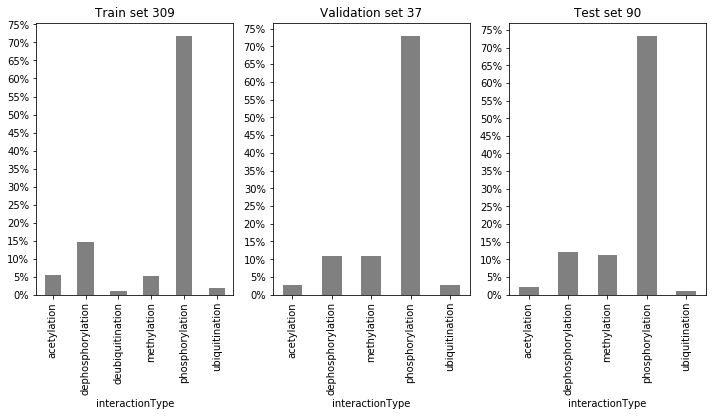

In [63]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(12,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set {}'.format(train.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
train.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(train.interactionType))).plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set {}'.format(val.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
val.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(val.interactionType))).plot.bar(ax=c_ax, color='gray')



c_ax = ax[2] 
c_ax.set_title('Test set {}'.format(test.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
test.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(test.interactionType))).plot.bar(ax=c_ax, color='gray')




plt.savefig("split_dataset_postfilter.eps", bbox_inches='tight')
plt.savefig("split_dataset_postfilter.png", bbox_inches='tight')

plt.show()

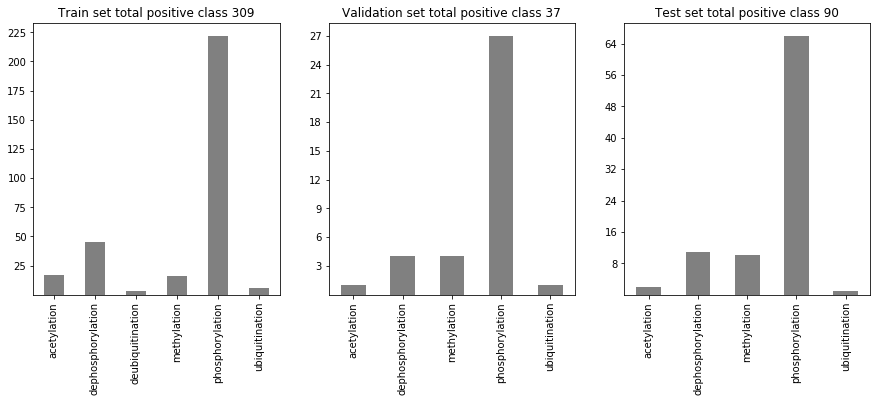

In [64]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set total positive class {}'.format(train.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
train.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set total positive class {}'.format(val.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
val.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')

c_ax = ax[2] 
c_ax.set_title('Test set total positive class {}'.format(test.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
test.interactionType.value_counts().sort_index().plot.bar(ax=c_ax,  color='gray')


plt.savefig('TrainTestValidationInteractionDistribution.eps', bbox_inches='tight')
plt.savefig('TrainTestValidationInteractionDistribution.png', bbox_inches='tight')


plt.show()

### Sample network

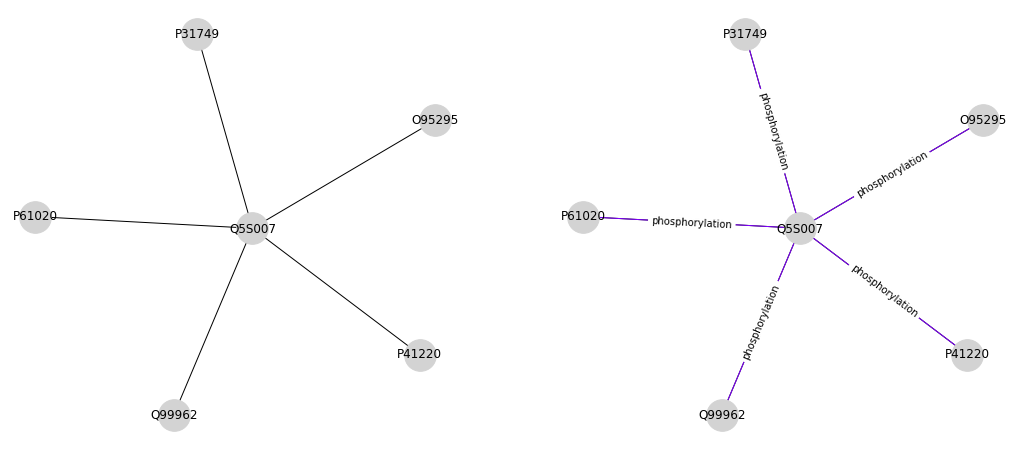

In [65]:
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(a=78, version=2)

fig,ax=plt.subplots(1,2, figsize=(18,8))

G=nx.Graph()
# Add nodes and edges
G.add_edges_from(train.query(" participant2Id =='Q5S007' and participant1Id != participant2Id")
                 .apply(lambda x: ( x["participant1Id"],x["participant2Id"], {"type": x['interactionType']}), axis=1))


pos = nx.spring_layout(G,  seed=80)

nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[0])


edge_label = nx.get_edge_attributes(G,'type')

colors = {i:random.randint(0, 50) for i in train['interactionType'].unique()}
edge_colors = [ colors[l]  for _,l in edge_label.items()]

cmap=plt.cm.get_cmap("rainbow")
vmin = min(edge_colors)
vmax = max(edge_colors)

nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[1])
nx.draw_networkx_edges(G, pos,  width=1.0, edge_color=edge_colors, edge_cmap=cmap, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_edge_labels(G, pos=pos,alpha=1, edge_labels = nx.get_edge_attributes(G,'type'), ax=ax[1])

plt.savefig('network.pdf', bbox_inches="tight")



plt.show()

### Generate negative samples

In [66]:

# def generate_negative_old(data):
#     import uuid
#     unique_pubmeds = data["pubmedId"].unique()
#     data_fake = pd.DataFrame(columns=data.columns)

#     num_fake_records = int( .50 * len(data))
#     #TODO: Randomise this, biased via
#     for u in unique_pubmeds:
#         fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
#         fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
#         fake_records.loc[:,"isValid"] = 'False' 
#         ## Copy of the pubmeid abtract and the title from a id
#         fake_records.loc[:,"pubmedId"] = u
#         fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
#         fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


#         data_fake = data_fake.append(fake_records, ignore_index=True)
#         if len(data_fake) > num_fake_records:
#             break
            
#     return data_fake
  
    

In [67]:

def generate_negative_entity(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)
        result = negative_samples_generator.transform(data)
        
        

        return result

In [68]:

def generate_negative_interaction(data):

    from datatransformer.interactionTypeNegativeSamplesAugmentor import InteractionTypeNegativeSamplesAugmentor

    import os
    
    negative_samples_generator = InteractionTypeNegativeSamplesAugmentor()
    result = negative_samples_generator.transform(data)


    return result

In [69]:
def generate_negative_missing_participant(data):


    import os
    
    data['isValid'] = data['isValid'].mask( (data['bothParticpantsExist'] == False) & (data['isValid'] == True) , False)


    return data

In [70]:
def plot_negative_distribution(train,val, test, heading, fig, ax  ):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    fig.suptitle(heading)
    #fig, ax = plt.subplots( 7,1, figsize=(45,30))
    c_ax= ax[0]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Training PPI {}".format( train.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    train.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[1]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Validation PPI {}".format(val.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    val.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[2]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Test PPI {}".format(test.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    test.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



   

#### Step1: Add negative entity pairs

In [71]:

train = generate_negative_entity(train, annotations_file)
test = generate_negative_entity(test,  annotations_file)
val = generate_negative_entity(val, annotations_file)



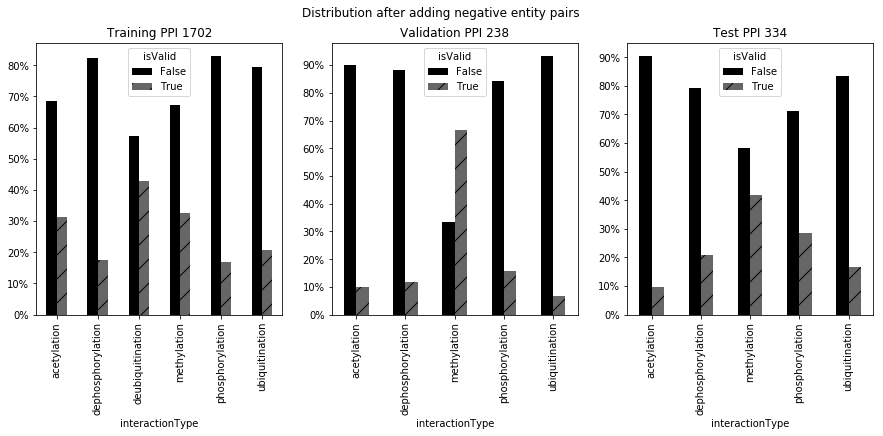

In [72]:
fig, ax = plt.subplots( 1,3, figsize=(15,5))

plt.style.use('grayscale')

plot_negative_distribution(train,  val, test, "Distribution after adding negative entity pairs",fig, ax)
plt.savefig("EntityNegativeSample.eps",bbox_inches = "tight")
plt.savefig("EntityNegativeSample.svg",bbox_inches = "tight")
plt.show()

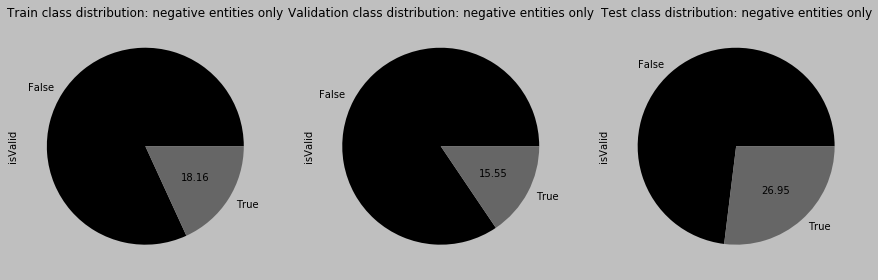

In [73]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution: negative entities only')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution: negative entities only')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution: negative entities only')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("PositiveVsNegative_EntityOnly.png")

In [74]:
train.query("pubmedId == '24291004' and isValid==False")[ ["pubmedId","interactionType", "participant1Id", "participant2Id", "pubmedabstract", "normalised_abstract", "annotations", "gene_to_uniprot_map"]]

,pubmedId,interactionType,participant1Id,participant2Id,pubmedabstract,normalised_abstract,annotations,gene_to_uniprot_map
497,24291004,phosphorylation,P04150,P60484,"Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the AKT1 kinase as a major negative regulator of the NR3C1 glucocorticoid receptor protein activity driving glucocorticoid resistance in T-ALL. Mechanistically, AKT1 impairs glucocorticoid-induced gene expression by direct phosphorylation of NR3C1 at position S134 and blocking glucocorticoid-induced NR3C1 translocation to the nucleus. Moreover, we demonstrate that loss of PTEN and consequent AKT1 activation can effectively block glucocorticoid-induced apoptosis and induce resistance to glucocorticoid therapy. Conversely, pharmacologic inhibition of AKT with MK2206 effectively restores glucocorticoid-induced NR3C1 translocation to the nucleus, increases the response of T-ALL cells to glucocorticoid therapy, and effectively reverses glucocorticoid resistance in vitro and in vivo.","Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the P31749 kinase as a major negative regulator of the P04150 glucocorticoid receptor protein activity driving glucocorticoid resistance in T-ALL. Mechanistically, P31749 impairs glucocorticoid-induced gene expression by direct phosphorylation of P04150 at position S134 and blocking glucocorticoid-induced P04150 translocation to the nucleus. Moreover, we demonstrate that loss of P60484 and consequent P31749 activation can effectively block glucocorticoid-induced apoptosis and induce resistance to glucocorticoid therapy. Conversely, pharmacologic inhibition of AKT with MK2206 effectively restores glucocorticoid-induced P04150 translocation to the nucleus, increases the response of T-ALL cells to glucocorticoid therapy, and effectively reverses glucocorticoid resistance in vitro and in vivo.","[{'start': '137', 'end': '141', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '186', 'end': '191', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '294', 'end': '298', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '375', 'end': '380', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '434', 'end': '439', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}, {'start': '508', 'end': '512', 'name': 'PTEN', 'type': 'Gene', 'normalised_id': '5728'}, {'start': '528', 'end': '532', 'name': 'AKT1', 'type': 'Gene', 'normalised_id': '207'}, {'start': '748', 'end': '753', 'name': 'NR3C1', 'type': 'Gene', 'normalised_id': '2908'}]","{'2908': ['P04150', 'E5KQF5', 'E5KQF6', 'F1D8N4', 'B7Z7I2'], '207': ['P31749', 'B0LPE5', 'B3KVH4'], '5728': ['P60484', 'F6KD01']}"
498,24291004,phosphorylation,P31749,P60484,"Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the AKT1 kinase as a major negative regulator of the NR3C1 glucocorticoid receptor protein activity driving glucocorticoid resistance in T-ALL. Mechanistically, AKT1 impairs glucocorticoid-induced gene expression by direct phosphorylation of NR3C1 at position S134 and blocking glucocorticoid-induced NR3C1 translocation to the nucleus. Moreover, we demonstrate that loss of PTEN and consequent AKT1 activation can effectively block glucocorticoid-induced apoptosis and induce resistance to glucocorticoid therapy. Conversely, pharmacologic inhibition of AKT with MK2206 effectively restores glucocorticoid-induced NR3C1 translocation to the nucleus, increases the response of T-ALL cells to glucocorticoid therapy, and effectively reverses glucocorticoid resistance in vitro and in vivo.","Glucocorticoid resistance is a major driver of therapeutic failure in T cell acute lymphoblastic leukemia (T-ALL). Here, we identify the P31749 kinase as a ma

In [75]:
train_file ="train_unique_negative_entity_only.json"
train.to_json(train_file)

test_file ="test_unique_negative_entity_only.json"
test.to_json(test_file)

val_file = "val_unique_negative_entity_only.json"
val.to_json(val_file)



In [76]:


from helpers.s3_util import S3Util

S3Util().uploadfile(train_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(test_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(val_file, "{}/".format( s3_results_prefix.rstrip("/")) )

2021-01-28 22:34:27,929 - helpers.s3_util - INFO - Uploading file train_unique_negative_entity_only.json s3://aegovan-data/processed_dataset/train_unique_negative_entity_only.json
2021-01-28 22:34:55,541 - helpers.s3_util - INFO - Uploading file test_unique_negative_entity_only.json s3://aegovan-data/processed_dataset/test_unique_negative_entity_only.json
2021-01-28 22:35:06,297 - helpers.s3_util - INFO - Uploading file val_unique_negative_entity_only.json s3://aegovan-data/processed_dataset/val_unique_negative_entity_only.json


In [77]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,37,17
dephosphorylation,211,45
deubiquitination,4,3
methylation,33,16
phosphorylation,1085,222
ubiquitination,23,6


In [78]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,9,1
dephosphorylation,30,4
methylation,2,4
phosphorylation,146,27
ubiquitination,14,1


In [79]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,19,2
dephosphorylation,42,11
methylation,14,10
phosphorylation,164,66
ubiquitination,5,1


In [80]:
pd.DataFrame(train.groupby(['interactionType', 'isValid']).size().unstack())

isValid,False,True
interactionType,,
acetylation,37,17
dephosphorylation,211,45
deubiquitination,4,3
methylation,33,16
phosphorylation,1085,222
ubiquitination,23,6


In [81]:
t = pd.DataFrame(train.groupby(['interactionType', 'isValid']).size().unstack())
t.columns =["False", "True"]

v = pd.DataFrame(val.groupby(['interactionType', 'isValid']).size().unstack())
v.columns = ["False", "True"]

b = pd.DataFrame(test.groupby(['interactionType', 'isValid']).size().unstack())
b.columns = ["False", "True"]

m = t.merge(v, left_index = True, right_index=True, how="left", suffixes=('_train', '_val'))\
       .merge(b, left_index = True, right_index=True, how="left")\

m=m.fillna(0)

m.loc["Total"] = m.apply(lambda x: sum(x))

m["TotalFalse"] =  m.apply(lambda x: sum( [ v for k,v in x.items() if 'false' in k.lower()]), axis=1)
m["TotalTrue"] =  m.apply(lambda x: sum( [ v for k,v in x.items() if 'true' in k.lower()]), axis=1)



print(m.astype('int32').to_latex())
    

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  False\_train &  True\_train &  False\_val &  True\_val &  False &  True &  TotalFalse &  TotalTrue \\
interactionType   &              &             &            &           &        &       &             &            \\
\midrule
acetylation       &           37 &          17 &          9 &         1 &     19 &     2 &          65 &         20 \\
dephosphorylation &          211 &          45 &         30 &         4 &     42 &    11 &         283 &         60 \\
deubiquitination  &            4 &           3 &          0 &         0 &      0 &     0 &           4 &          3 \\
methylation       &           33 &          16 &          2 &         4 &     14 &    10 &          49 &         30 \\
phosphorylation   &         1085 &         222 &        146 &        27 &    164 &    66 &        1395 &        315 \\
ubiquitination    &           23 &           6 &         14 &         1 &      5 &     1 &          42 &          8 \\
Total         

In [82]:
feature_cols = ["pubmedId","pubmedabstract","annotations", "num_unique_gene_normalised_id", "num_gene_normalised_id", "normalised_abstract", "participant1Id", "participant2Id", "gene_to_uniprot_map"]

derive_class_func = lambda r: r["interactionType"] if r["isValid"] else "other"


In [83]:

train_multiclass = train[ feature_cols]
train_multiclass["class"] = train.apply( derive_class_func, axis=1)

test_multiclass =  test[ feature_cols]
test_multiclass["class"] = test.apply( derive_class_func, axis=1)

val_multiclass =  val[ feature_cols]
val_multiclass["class"] = val.apply( derive_class_func, axis=1)

/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/aeg/miniconda/envs/kegg_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [84]:
feature_cols = ["pubmedId","pubmedabstract", "annotations", "num_unique_gene_normalised_id", "num_gene_normalised_id","normalised_abstract", "participant1Id", "participant2Id","gene_to_uniprot_map", "class"]


train_multiclass = train_multiclass[ feature_cols]
test_multiclass = test_multiclass[ feature_cols]
val_multiclass = val_multiclass[ feature_cols]




In [85]:
train_multiclass["class"].value_counts()

other                1393
phosphorylation       222
dephosphorylation      45
acetylation            17
methylation            16
ubiquitination          6
deubiquitination        3
Name: class, dtype: int64

In [86]:
test_multiclass["class"].value_counts()

other                244
phosphorylation       66
dephosphorylation     11
methylation           10
acetylation            2
ubiquitination         1
Name: class, dtype: int64

In [87]:
val_multiclass["class"].value_counts()

other                201
phosphorylation       27
methylation            4
dephosphorylation      4
ubiquitination         1
acetylation            1
Name: class, dtype: int64

In [88]:
train_multi_file="train_multiclass.json"
train_multiclass.to_json(train_multi_file)

test_multi_file="test_multiclass.json"
test_multiclass.to_json(test_multi_file)

val_multi_file="val_multiclass.json"
val_multiclass.to_json(val_multi_file)

In [89]:
val_multiclass.head(n=1)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,gene_to_uniprot_map,class
0,26869104,"NBS1 is an early component in DNA-Damage Response (DDR) that participates in the initiation of the responses aiming to repair double-strand breaks caused by different mechanisms. Early steps in DDR have to react to local alterations in chromatin that are induced by DNA damage. NBS1 participates in the early detection of DNA damage and functions as a platform for the recruitment and assembly of components that are sequentially required for the repair process. In this work we have studied whether the VRK1 chromatin kinase can affect the activation of NBS1 in response to DNA damage induced by ionizing radiation. VRK1 is forming a basal preassembled complex with NBS1 in non-damaged cells. Knockdown of VRK1 resulted in the loss of NBS1 foci induced by ionizing radiation, an effect that was also detected in cell-cycle arrested cells and in ATM (-/-) cells. The phosphorylation of NBS1 in Ser343 by VRK1 is induced by either doxorubicin or IR in ATM (-/-) cells. Phosphorylated NBS1 is also complexed with VRK1. NBS1 phosphorylation by VRK1 cooperates with ATM. This phosphorylation of NBS1 by VRK1 contributes to the stability of NBS1 in ATM (-/-) cells, and the consequence of its loss can be prevented by treatment with the MG132 proteasome inhibitor of RNF8. We conclude that VRK1 regulation of NBS1 contributes to the stability of the repair complex and permits the sequential steps in DDR.","[{'start': '0', 'end': '4', 'name': 'NBS1', 'type': 'Gene', 'normalised_id': '4683'}, {'start': '278', 'end': '282', 'name': 'NBS1', 'type': 'Gene', 'normalised_id': '4683'}, {'start': '504', 'end': '508', 'name': 'VRK1', 'type': 'Gene', 'normalised_id': '7443'}, {'start': '555', 'end': '559', 'name': 'NBS1', 'type': 'Gene', 'normalised_id': '4683'}, {'start': '617', 'end': '621', 'name': 'VRK1', 'type': 'Gene', 'normalised_id': '7443'}, {'start': '667', 'end': '671', 'name': 'NBS1', 'type': 'Gene', 'normalised_id': '4683'}, {'start': '707', 'end': '711', 'name': 'VRK1', 'type': 'Gene', 'normalised_id': '7443'}, {'start': '736', 'end': '740', 'name': 'NBS1', 'type': 'Gene', 'normalised_id': '4683'}, {'start': '846', 'end': '849', 'name': 'ATM', 'type': 'Gene', 'normalised_id': '472'}, {'start': '886', 'end': '890', 'name': 'NBS1', 'type': 'Gene', 'normalised_id': '4683'}, {'start': '904', 'end': '908', 'name': 'VRK1', 'type': 'Gene', 'normalised_id': '7443'}, {'start': '951', 'end': '954', 'name': 'ATM', 'type': 'Gene', 'normalised_id': '472'}, {'start': '983', 'end': '987', 'name': 'NBS1', 'type': 'Gene', 'normalised_id': '4683'}, {'start': '1011', 'end': '1015', 'name': 'VRK1', 'type': 'Gene', 'normalised_id': '7443'}, {'start': '1017', 'end': '1021', 'name': 'NBS1', 'type': 'Gene', 'normalised_id': '4683'}, {'start': '1041', 'end': '1045', 'name': 'VRK1', 'type': 'Gene', 'normalised_id': '7443'}, {'start': '1062', 'end': '1065', 'name': 'ATM', 'type': 'Gene', 'normalised_id': '472'}, {'start': '1091', 'end': '1095', 'name': 'NBS1', 'type': 'Gene', 'normalised_id': '4683'}, {'start': '1099', 'end': '1103', 'name': 'VRK1', 'type': 'Gene', 'normalised_id': '7443'}, {'start': '1136', 'end': '1140', 'name': 'NBS1', 'type': 'Gene', 'normalised_id': '4683'}, {'start': '1144', 'end': '1147', 'name': 'ATM', 'type': 'Gene', 'normalised_id': '472'}, {'start': '1232', 'end': '1237', 'name': 'MG132', 'type': 'Gene', 'normalised_id': '875581'}, {'start': '1262', 'end': '1266', 'name': 'RNF8', 'type': 'Gene', 'normalised_id': '9025'}, {'start': '1285', 'end': '1289', 'name': 'VRK1', 'type': 'Gene', 'normalised_id': '7443'}, {'start': '1304', 'end': '1308', 'name': 'NBS1', 'type': 'Gene', 'normalised_id': '4683'}]",5,25,"O60934 is an early component in DNA-Damage Response (DDR) that participates in the initiation of the responses aiming to repair double-strand breaks caused by different me

In [90]:
from helpers.s3_util import S3Util

S3Util().uploadfile(val_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(test_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(train_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )

2021-01-28 22:35:24,705 - helpers.s3_util - INFO - Uploading file val_multiclass.json s3://aegovan-data/processed_dataset/val_multiclass.json
2021-01-28 22:35:34,338 - helpers.s3_util - INFO - Uploading file test_multiclass.json s3://aegovan-data/processed_dataset/test_multiclass.json
2021-01-28 22:35:43,058 - helpers.s3_util - INFO - Uploading file train_multiclass.json s3://aegovan-data/processed_dataset/train_multiclass.json


In [91]:
train_multiclass.sample(n=50).to_json("sample_train_multiclass.json")

#### Step 2: Add negative interaction types

In [92]:

# train = generate_negative_interaction(train)
# test = generate_negative_interaction(test)
# val = generate_negative_interaction(val)


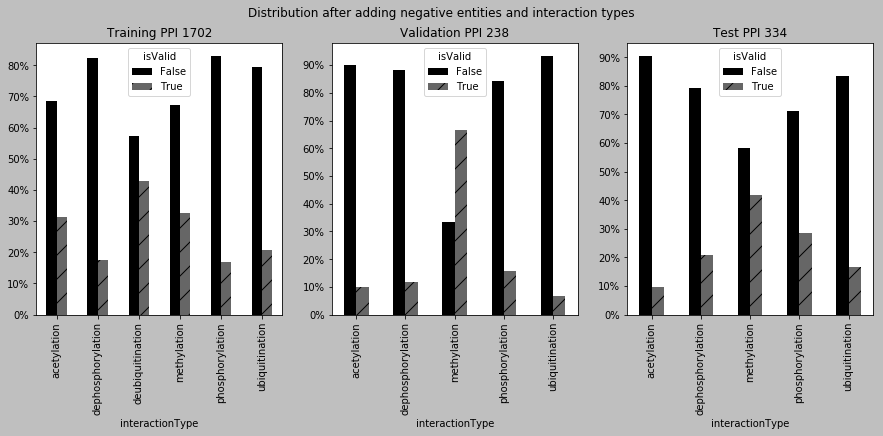

In [93]:

fig, ax = plt.subplots( 1,3, figsize=(15,5))

plot_negative_distribution(train,  val, test, "Distribution after adding negative entities and interaction types",fig, ax)
plt.savefig("EntityInteractionNegativeSample.png",bbox_inches = "tight")
plt.savefig("EntityInteractionNegativeSample.svg",bbox_inches = "tight")
plt.show()

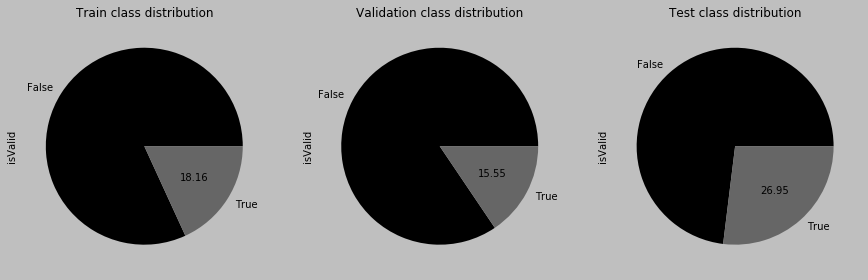

In [94]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("Interaction.png")

In [95]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,37,17
dephosphorylation,211,45
deubiquitination,4,3
methylation,33,16
phosphorylation,1085,222
ubiquitination,23,6


In [96]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,19,2
dephosphorylation,42,11
methylation,14,10
phosphorylation,164,66
ubiquitination,5,1


In [97]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,9,1
dephosphorylation,30,4
methylation,2,4
phosphorylation,146,27
ubiquitination,14,1


In [98]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,19,2
dephosphorylation,42,11
methylation,14,10
phosphorylation,164,66
ubiquitination,5,1


In [99]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,9,1
dephosphorylation,30,4
methylation,2,4
phosphorylation,146,27
ubiquitination,14,1


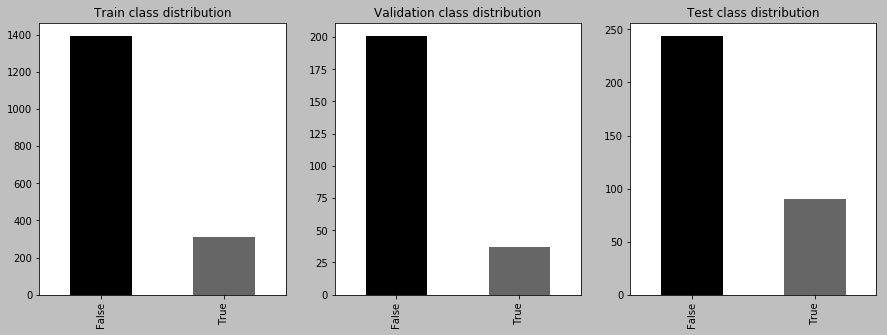

In [100]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.bar( ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.bar( ax=ax[1])


ax[2].set_title('Test class distribution')
test.isValid.value_counts().plot.bar( ax=ax[2])



plt.savefig("Interaction.png")

In [101]:
train.to_json("train_unique_pub_v6_max_neg.json")
test.to_json("test_unique_pub_v6_max_neg.json")
val.to_json("val_unique_pub_v6_max_neg.json")

In [102]:
train.sample(n=20).to_json("sample_train.json")

In [103]:
train.query('isValid == True').sample(n=3)

,entityMentionsCount,hasTriggerWord,interactionId,interactionType,isValid,lessThanThreshold,participant1Alias,participant1Id,participant2Alias,participant2Id,participants_count,pubmedId,pubmedTitle,pubmedabstract,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
1533,9,True,637098,phosphorylation,True,True,"[[prp4b_human], [Serine/threonine-protein kinase PRP4 homolog], [PRPF4B], [KIAA0536], [PRP4], [PRP4H], [PRP4K], [PRP4 pre-mRNA-processing factor 4 homolog], [PRP4 kinase]]",Q13523,"[[klf13_human], [Krueppel-like factor 13], [KLF13], [BTEB3], [NSLP1], [Transcription factor BTEB3], [Basic transcription element-binding protein 3], [RANTES factor of late activated T-lymphocytes 1], [Transcription factor NSLP1], [Novel Sp1-like zinc finger transcription factor 1]]",Q9Y2Y9,2,17513757,None,"Activation of resting T lymphocytes initiates differentiation into mature effector cells over 3-7 days. The chemokine CCL5 (RANTES) and its major transcriptional regulator, Krüppel-like factor 13 (KLF13), are expressed late (3-5 days) after activation in T lymphocytes. Using yeast two-hybrid screening of a human thymus cDNA library, PRP4, a serine/threonine protein kinase, was identified as a KLF13-binding protein. Specific interaction of KLF13 and PRP4 was confirmed by reciprocal coimmunoprecipitation. PRP4 is expressed in PHA-stimulated human T lymphocytes from days 1 and 7 with a peak at day 3. Using an in vitro kinase assay, it was found that PRP4 phosphorylates KLF13. Furthermore, although phosphorylation of KLF13 by PRP4 results in lower binding affinity to the A/B site of the CCL5 promoter, coexpression of PRP4 and KLF13 increases nuclear localization of KLF13 and CCL5 transcription. Finally, knock-down of PRP4 by small interfering RNA markedly decreases CCL5 expression in T lymphocytes. Thus, PRP4-mediated phosphorylation of KLF13 plays a role in the regulation of CCL5 expression in T lymphocytes.","Activation of resting T lymphocytes initiates differentiation into mature effector cells over 3-7 days. The chemokine P13501 (P13501) and its major transcriptional regulator, Q9Y2Y9 (Q9Y2Y9), are expressed late (3-5 days) after activation in T lymphocytes. Using yeast two-hybrid screening of a human thymus cDNA library, Q13523, a serine/threonine protein kinase, was identified as a Q9Y2Y9-binding protein. Specific interaction of Q9Y2Y9 and Q13523 was confirmed by reciprocal coimmunoprecipitation. Q13523 is expressed in PHA-stimulated human T lymphocytes from days 1 and 7 with a peak at day 3. Using an in vitro kinase assay, it was found that Q13523 phosphorylates Q9Y2Y9. Furthermore, although phosphorylation of Q9Y2Y9 by Q13523 results in lower binding affinity to the A/B site of the P13501 promoter, coexpression of Q13523 and Q9Y2Y9 increases nuclear localization of Q9Y2Y9 and P13501 transcription. Finally, knock-down of Q13523 by small interfering RNA markedly decreases P13501 expression in T lymphocytes. Thus, Q13523-mediated phosphorylation of Q9Y2Y9 plays a role in the regulation of P13501 expression in T lymphocytes.","[{'start': '118', 'end': '122', 'name': 'CCL5', 'type': 'Gene', 'normalised_id': '6352'}, {'start': '124', 'end': '130', 'name': 'RANTES', 'type': 'Gene', 'normalised_id': '6352'}, {'start': '173', 'end': '194', 'name': 'Krppel-like factor 13', 'type': 'Gene', 'normalised_id': '51621'}, {'start': '196', 'end': '201', 'name': 'KLF13', 'type': 'Gene', 'normalised_id': '51621'}, {'start': '307', 'end': '312', 'name': 'human', 'type': 'Species', 'normalised_id': '9606'}, {'start': '334', 'end': '338', 'name': 'PRP4', 'type': 'Gene', 'normalised_id': '8899'}, {'start': '395', 'end': '400', 'name': 'KLF13', 'type': 'Gene', 'normalised_id': '51621'}, {'start': '442', 'end': '447', 'name': 'KLF13', 'type': 'Gene', 'normalised_id': '51621'}, {'start': '452', 'end': '456', 'name': 